In [37]:
import torch.nn as nn
import torchvision
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

In [38]:
# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
img_size = 64
color_channels = 3
latent_vector_size = 100
feature_map_size = 64
training_episodes = 48
learning_rate_g = 0.0002
learning_rate_d = 0.0002
beta1 = 0.5

In [3]:
# Dataset loading
folder_train = torchvision.datasets.ImageFolder(
    root="../train_gan",
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(img_size),
        torchvision.transforms.CenterCrop(img_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

train_loader = torch.utils.data.DataLoader(
    folder_train,
    batch_size=batch_size,
    shuffle=True
)

In [39]:
# Initialize weights according to the paper
def init_c(layer):
    nn.init.normal_(layer.weight.data, 0.0, 0.02)
    return layer

def init_bn(layer):
    nn.init.normal_(layer.weight.data, 1.0, 0.02)
    nn.init.constant_(layer.bias.data, 0)
    return layer

In [40]:
# Generator for mapping latent vector to img
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            # Latent vector to feature map
            nn.ConvTranspose2d(latent_vector_size, 8 * feature_map_size, 4, 1, 0, bias=False),
            init_bn(nn.BatchNorm2d(8 * feature_map_size)),
            nn.ReLU(True),
            # Blocks
            nn.ConvTranspose2d(8 * feature_map_size, 4 * feature_map_size, 4, 2, 1, bias=False),
            init_bn(nn.BatchNorm2d(4 * feature_map_size)),
            nn.ReLU(True),
            nn.ConvTranspose2d(4 * feature_map_size, 2 * feature_map_size, 4, 2, 1, bias=False),
            init_bn(nn.BatchNorm2d(2 * feature_map_size)),
            nn.ReLU(True),
            nn.ConvTranspose2d(2 * feature_map_size, feature_map_size, 4, 2, 1, bias=False),
            init_bn(nn.BatchNorm2d(feature_map_size)),
            nn.ReLU(True),
            # Feature map to img
            nn.ConvTranspose2d(feature_map_size, color_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.network(x)


In [41]:
# Discriminator for guessing whether the image is real or fake
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            # 3 channel input to feature maps
            init_c(nn.Conv2d(color_channels, feature_map_size, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # Convolutional blocks
            init_c(nn.Conv2d(feature_map_size, 2 * feature_map_size, 4, 2, 1, bias=False)),
            init_bn(nn.BatchNorm2d(2 * feature_map_size)),
            nn.LeakyReLU(0.2, inplace=True),
            init_c(nn.Conv2d(2 * feature_map_size, 4 * feature_map_size, 4, 2, 1, bias=False)),
            init_bn(nn.BatchNorm2d(4 * feature_map_size)),
            nn.LeakyReLU(0.2, inplace=True),
            init_c(nn.Conv2d(4 * feature_map_size, 8 * feature_map_size, 4, 2, 1, bias=False)),
            init_bn(nn.BatchNorm2d(8 * feature_map_size)),
            nn.LeakyReLU(0.2, inplace=True),
            # Feature maps to prediction
            init_c(nn.Conv2d(8 * feature_map_size, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

In [42]:
# Create both models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Create criterion
criterion = nn.BCELoss()

# Create optimizers
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate_g, betas=(beta1, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_d, betas=(beta1, 0.999))

# Create preview noise
noise = torch.randn(1, latent_vector_size, 1, 1).to(device)

In [8]:
# Training Loop

# Lists to keep track of progress
img_list = []
generator_losses = []
discriminator_losses = []

for episode in range(training_episodes):
    for i, data in enumerate(train_loader, 0):
        ### Update discriminator
        discriminator.zero_grad()

        ## Real batch
        # Format real batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), 1.0, dtype=torch.float, device=device)

        # Send real images to discriminator
        output = discriminator(real_images).view(-1)

        # Calculate discriminator loss on real images
        loss_real = criterion(output, label)
        loss_real.backward()

        ## Fake batch
        # Generate random noise
        noise = torch.randn(b_size, latent_vector_size, 1, 1, device=device)

        # Generate random images using generator
        fake = generator(noise)
        label.fill_(0.0)

        # Send fake images to discriminator
        output = discriminator(fake.detach()).view(-1)

        # Calculate discriminator loss on fake images
        loss_fake = criterion(output, label)
        loss_fake.backward()

        # Step discriminator optimizer
        loss_discriminator = loss_real + loss_fake
        optimizer_d.step()

        ### Update generator
        generator.zero_grad()

        # Trick discriminator output on real images
        label.fill_(1.0)
        output = discriminator(fake).view(-1)

        # Calculate generator loss
        loss_generator = criterion(output, label)
        loss_generator.backward()
        optimizer_g.step()

        # Stats
        generator_losses.append(loss_generator.item())
        discriminator_losses.append(loss_discriminator.item())

        # Print losses
        if i % 50 == 0:
            print(f"[{episode}/{training_episodes}][{i}/{len(train_loader)}] "
                  f"Discriminator Loss: {loss_discriminator.item():.3f} "
                  f"Generator Loss: {loss_generator.item():.3f}")


    # Check generator progress
    with torch.no_grad():
        preview_img = generator(noise).detach().cpu()
    img_list.append(preview_img)


[0/24][0/243] Discriminator Loss: 1.871 Generator Loss: 7.345
[0/24][50/243] Discriminator Loss: 1.675 Generator Loss: 16.816
[0/24][100/243] Discriminator Loss: 1.415 Generator Loss: 11.995
[0/24][150/243] Discriminator Loss: 1.614 Generator Loss: 4.841
[0/24][200/243] Discriminator Loss: 0.954 Generator Loss: 4.017
[1/24][0/243] Discriminator Loss: 1.103 Generator Loss: 4.406
[1/24][50/243] Discriminator Loss: 0.892 Generator Loss: 1.986
[1/24][100/243] Discriminator Loss: 1.365 Generator Loss: 4.732
[1/24][150/243] Discriminator Loss: 0.790 Generator Loss: 2.447
[1/24][200/243] Discriminator Loss: 1.105 Generator Loss: 0.973
[2/24][0/243] Discriminator Loss: 0.822 Generator Loss: 3.040
[2/24][50/243] Discriminator Loss: 1.112 Generator Loss: 3.503
[2/24][100/243] Discriminator Loss: 1.618 Generator Loss: 2.387
[2/24][150/243] Discriminator Loss: 0.919 Generator Loss: 2.345
[2/24][200/243] Discriminator Loss: 0.820 Generator Loss: 2.588
[3/24][0/243] Discriminator Loss: 0.821 Generat

In [9]:
# Save the trained models
torch.save(generator.state_dict(), "../trained/generator.pth")
torch.save(discriminator.state_dict(), "../trained/discriminator.pth")

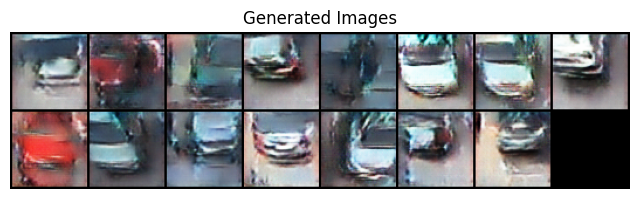

In [16]:
# Plot output images in a grid
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(img_list[-1], padding=2, normalize=True),(1,2,0)))
plt.show()

In [53]:
# Load the trained generator model for inference
inference_generator = Generator().to(device)
inference_generator.load_state_dict(torch.load("../trained/generator.pth", weights_only=True, map_location=device))
inference_generator.eval()

# Parameters
num_images = 16
imgs = []

# Generate new images
with torch.no_grad():
    for i in range(num_images):
        noise = torch.randn(1, latent_vector_size, 1, 1).to(device)
        generated_image = inference_generator(noise).detach().cpu()
        imgs.append(generated_image)


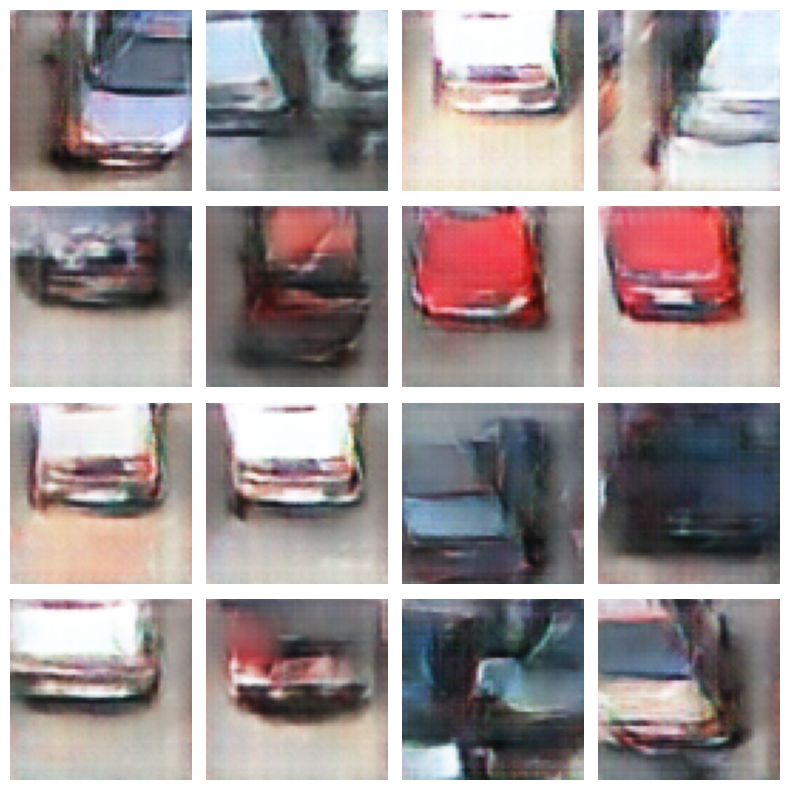

In [54]:
# Plot denormalized images
plt.figure(figsize=(8,8))
for i in range(num_images):
    plt.subplot(4, 4, i+1)
    plt.axis("off")
    plt.imshow(np.transpose(imgs[i][0], (1, 2, 0)) * 0.5 + 0.5)
plt.tight_layout()
plt.show()

In [21]:
# Save denormalized images to train_generated_imgs folder
for idx, img_tensor in enumerate(imgs):
    img = img_tensor[0]
    img = (img * 0.5 + 0.5) * 255
    img = img.numpy().astype(np.uint8)
    img = np.transpose(img, (1, 2, 0))
    pil_img = Image.fromarray(img)
    pil_img.save(f"../train_generated_imgs/generated_img_{idx+1}.png")